In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import cv2
import numpy as np
import rootutils
from PIL import Image

from IPython.display import display

# Set python paths
notebook_path = Path.cwd()  # Gets the current working directory
rootutils.setup_root(notebook_path, indicator="pyproject.toml", pythonpath=True, cwd=True)

# Load necessary local modules
from src.utils.camera import load_cam_infos, project_to_2d
from src.utils.image import undistort_image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Set Helper Variables

We know that:
- X+: Forward
- Y+: Up
- Z+: Left

In [14]:
COLORS = [
    (255, 0, 0),  # Red
    (0, 255, 0),  # Green
    (0, 0, 255),  # Blue
    (128, 0, 128),  # Purple
]

# These are the points we want to project
# points_3d = np.array(
#     [
#         [0.54, 0, 0.54], # (red): Forward, Left
#         [-0.54, 0.0, 0.54], # (green): Backward, Left
#         [-0.54, 0.0, -0.54], # (blue): Backward, Right
#         [0.54, 0.0, -0.54], # (purple): Forward, Right
#     ]
# ) / 2
points_3d = np.array(
    [
        [-3.61109276, -34.26141132, 16.34467729],
        [-3.72498064, -34.18235353, 16.59624692],
        [-3.78372375, -34.24340968, 16.35859741],
    ]
)

# Set Paths
PATH_TO_DATA = Path("data")
RECORDING = "20250227_Testing" # "20250206_Testing"
PATH_TO_TRIAL = PATH_TO_DATA / RECORDING

FRAME_NUMBER = 400
marshall_path = PATH_TO_TRIAL / "Marshall" / "recording" / "export"
orrbec_path = PATH_TO_TRIAL / "Orbbec" / "color"

# Cameras we want to project
CAMERAS = ["camera_01", "camera_02", "camera_03", "camera_04", "camera_05", "camera_06"]
CAMERAS = CAMERAS[-2:]

# Load camera parameters
cam_infos = load_cam_infos(PATH_TO_TRIAL)

Projecting the 3D Points back into 2D

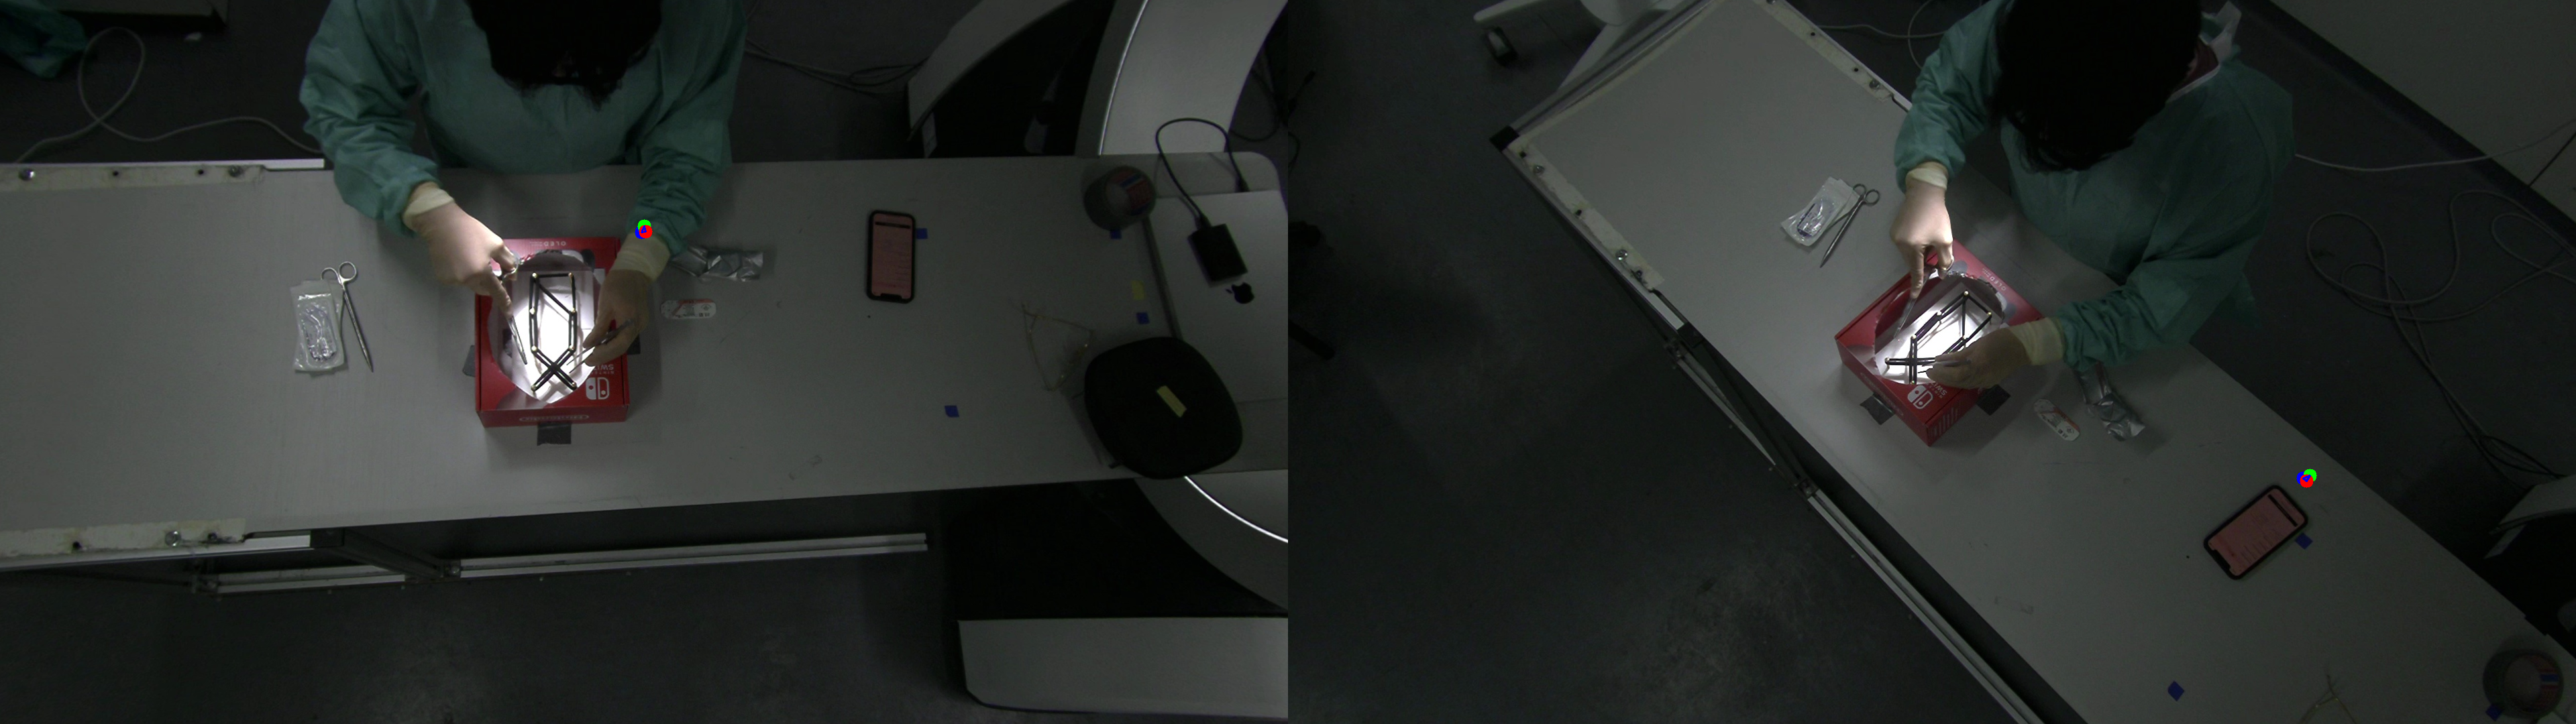

In [15]:
# Store the images
images = []

for cam in CAMERAS:
    cam_params = cam_infos[cam]
    cam_id = int(cam[-1])

    # Marshall Camera
    if cam_id >= 5:
        # Read the image
        img = cv2.imread(str(marshall_path / f"color_{FRAME_NUMBER:06d}_camera{cam_id - 4:02d}.jpg"))
        # Undistort the image
        img = cv2.undistort(
            img,
            cam_params["K"],
            np.array(
                [cam_params["radial_params"][0]]
                + [cam_params["radial_params"][1]]
                + list(cam_params["tangential_params"][:2])
                + [cam_params["radial_params"][2]]
                + [0, 0, 0]
            ),
        )

    else:
        # Read the image
        img = cv2.imread(str(orrbec_path / f"color_{FRAME_NUMBER:06d}_camera{cam_id:02d}.jpg"))
        # Undistort the image
        img = undistort_image(img, cam_params, "color")

    # List to store the 2D points on the image
    points_2d = project_to_2d(
        points_3d.T,
        cam_params["K"],
        np.linalg.inv(cam_params["T_world_camera"]),
    )
    for i, point_2d in enumerate(points_2d.T):
        # Draw the point on the image
        cv2.circle(
            img,
            (int(point_2d[0]), int(point_2d[1])),
            10,
            COLORS[i % len(COLORS)],
            thickness=-1,
        )

    # Draw lines between the points
    for i in range(len(points_2d.T)):
        for j in range(i + 1, len(points_2d.T)):
            cv2.line(img, points_2d[:,i], points_2d[:, j], (255, 0, 0), 2)

    images.append(img)

# Determine the number of rows needed
num_columns = 2
num_rows = (len(images) + num_columns - 1) // num_columns

# Create a blank canvas to place the images
height, width, _ = images[0].shape
canvas = np.zeros((height * num_rows, width * num_columns, 3), dtype=np.uint8)

# Place each image in the canvas
for idx, img in enumerate(images):
    row = idx // num_columns
    col = idx % num_columns
    canvas[row * height : (row + 1) * height, col * width : (col + 1) * width, :] = img

pil_image = Image.fromarray(canvas[..., ::-1])

# Display the image
display(pil_image)